In [79]:
import math
import numpy as np
import pandas as pd

# used for EDA and visualizing results
import matplotlib.pyplot as plt
import seaborn as sns

# Used for model evaluation
from sklearn.metrics import accuracy_score, confusion_matrix
# used for regression method
from sklearn.svm import SVR
# Generalized feature importance that can be applied to regression
from sklearn.inspection import permutation_importance
# Used to split data into train and test data
from sklearn.model_selection import train_test_split
# used for classification method
from sklearn.ensemble import RandomForestClassifier
# used for hyperparameter tuning
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
# Used for regression model evaluation
from sklearn.metrics import mean_squared_error




# Problem Description

The Kaggle dataset student_performance_updated_1000.csv from [here](https://www.kaggle.com/datasets/haseebindata/student-performance-predictions) includes behaviorial student data for 1000 students such as extracurricular activities and their level of parental support, as well as educational factors such as study hours per week, attendance, and whether classes are taken online. The goal of this project is to predict the final letter grade of the student with a couple of methods: 
* applying regression modeling to predict the number grade and using that to assess the letter grade and 
* applying classification modeling to predict the letter grade directly

Github Repo- [here](https://github.com/cfildish/CU_AI/tree/main/CSCA_5622_Supervised_Learning)

# Data Ingest

In [25]:
df = pd.read_csv("student_performance_updated_1000.csv")
df.head()


,StudentID,Name,Gender,AttendanceRate,StudyHoursPerWeek,PreviousGrade,ExtracurricularActivities,ParentalSupport,FinalGrade,Study Hours,Attendance (%),Online Classes Taken
0,1.0,John,Male,85.0,15.0,78.0,1.0,High,80.0,4.8,59.0,False
1,2.0,Sarah,Female,90.0,20.0,85.0,2.0,Medium,87.0,2.2,70.0,True
2,3.0,Alex,Male,78.0,10.0,65.0,0.0,Low,68.0,4.6,92.0,False
3,4.0,Michael,Male,92.0,25.0,90.0,3.0,High,92.0,2.9,96.0,False
4,5.0,Emma,Female,NaN,18.0,82.0,2.0,Medium,85.0,4.1,97.0,True


# EDA

## Investigate Data

1. Determine the total amount of NA values in each column
2. Plot general statistics for each column:
3. Investigate the correlation matrix and pairplot


In [26]:
print(f"Total Students: {len(df)}")

Total Students: 1000


#### NA Values

In [27]:
print("NA Values")
df.isna().sum()

NA Values


StudentID                    40
Name                         34
Gender                       48
AttendanceRate               40
StudyHoursPerWeek            50
PreviousGrade                33
ExtracurricularActivities    43
ParentalSupport              22
FinalGrade                   40
Study Hours                  24
Attendance (%)               41
Online Classes Taken         25
dtype: int64

NaN values are low relative to the length of the dataframe, which we'll look to interpolate

Drop all rows where FinalGrade is NA since it's the response we'll be predicting on

In [67]:
df = df.dropna(subset=["FinalGrade"])

#### Basic statistics on individual columns

In [28]:
df.describe()

,StudentID,AttendanceRate,StudyHoursPerWeek,PreviousGrade,ExtracurricularActivities,FinalGrade,Study Hours,Attendance (%)
count,960.000000,960.000000,950.000000,967.000000,957.000000,960.000000,976.000000,959.000000
mean,5416.019792,85.510417,17.630526,77.598759,1.520376,80.030208,2.406967,77.248175
std,2653.748319,7.332125,6.272132,10.006640,1.046439,9.493652,1.620267,19.298148
min,1.000000,70.000000,8.000000,60.000000,0.000000,62.000000,-5.000000,50.000000
25%,3113.500000,82.000000,12.000000,70.000000,1.000000,72.000000,1.200000,63.000000
50%,5396.500000,88.000000,18.000000,78.000000,1.000000,80.000000,2.500000,76.000000
75%,7754.750000,91.000000,22.000000,86.000000,2.000000,88.000000,3.700000,89.000000
max,9998.000000,95.000000,30.000000,90.000000,3.000000,92.000000,5.000000,200.000000


A few notes for the data above-
* Study hours has a minimum of -5, but should have a minimum of 0
* Attendance percentage has a max percentage of 200, but should have a max of 100
* StudentID and Name are identifier columns that won't add explanatory value to the response
* There are columns for AttendanceRate and Attendance (%) and Study Hours and StudyHoursPerWeek we'll need to see if there aren't high correlations between the two

We address these notes below

In [29]:
# Replace negative study hours with zero
df.loc[df["Study Hours"] < 0] = 0

# Replace attendace %s above 100 down to 100
df.loc[df["Attendance (%)"] > 100] = 100

# drop StudentID and Name since they are identifier columns that are unrelated to grade
df = df.drop(columns = ["StudentID", "Name"])

#### Pair plot

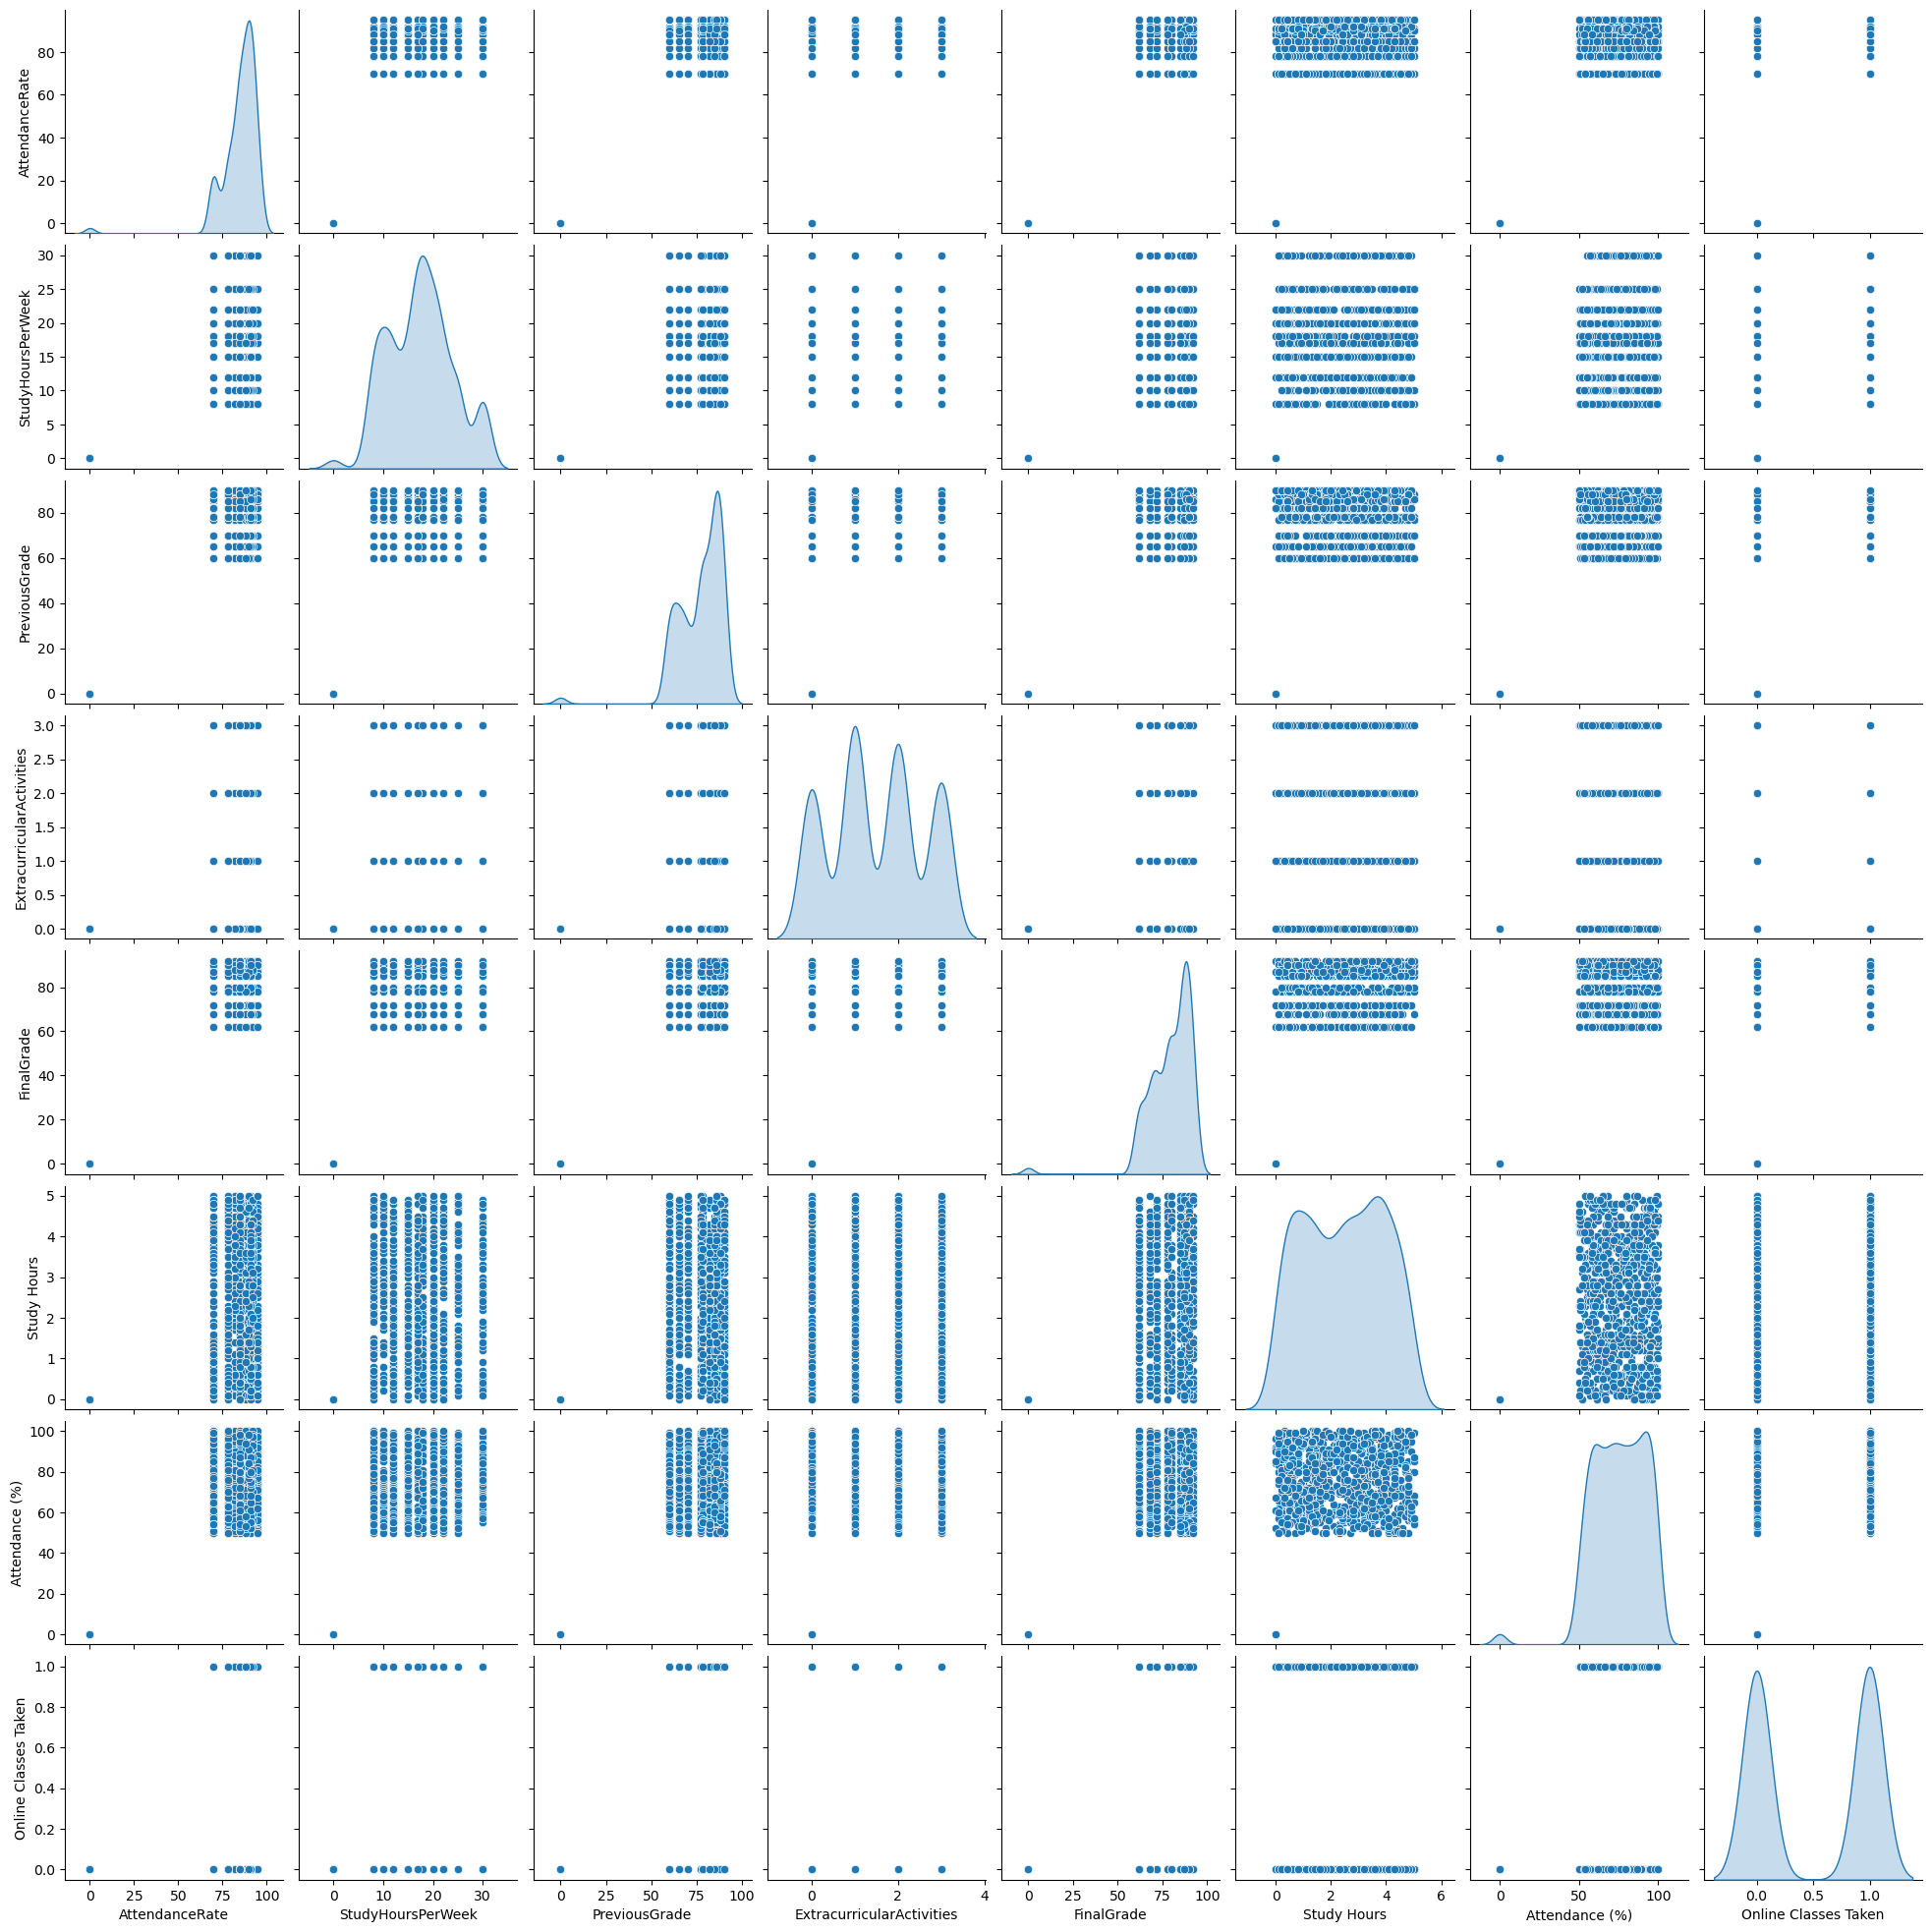

In [40]:
sns.pairplot(df, diag_kind="kde")

It looks like most of the columns are integers- for that reason we could treat columns such as Extracurricular Activities as categorical variables and create dummy columns for each category, but most of the integers are numbers on a scale in this case, not labels.

Also it looks like there's one row that has zeros for most integer columns, we drop the column below.

In [44]:
df = df.loc[df["FinalGrade"] > 0]


#### Correlation Matrix

In [33]:
# Check the correlation to determine if both attendance and study hour columns need to be kept
df.corr().style.background_gradient(cmap='coolwarm')

,AttendanceRate,StudyHoursPerWeek,PreviousGrade,ExtracurricularActivities,FinalGrade,Study Hours,Attendance (%)
AttendanceRate,1.000000,0.236055,0.498830,0.101262,0.503204,0.115547,0.384847
StudyHoursPerWeek,0.236055,1.000000,0.170267,0.077659,0.213593,0.034256,0.184445
PreviousGrade,0.498830,0.170267,1.000000,0.140108,0.413378,0.077167,0.335742
ExtracurricularActivities,0.101262,0.077659,0.140108,1.000000,0.076086,-0.011324,0.060625
FinalGrade,0.503204,0.213593,0.413378,0.076086,1.000000,0.148151,0.335350
Study Hours,0.115547,0.034256,0.077167,-0.011324,0.148151,1.000000,0.077760
Attendance (%),0.384847,0.184445,0.335742,0.060625,0.335350,0.077760,1.000000


In the correlation matrix above, the pairings I'd suspect to be highly correlated aren't as much as I expected:
* PreviousGrade and FinalGrade- 0.413378
* StudyHoursPerWeek and Study Hours- 0.034256
* Attendance (%) and AttendaceRate- 0.384847

It could be because of the fact that the columns are discrete so the distances are also discrete and not as accurate.

#### Plot histograms of the pairs above

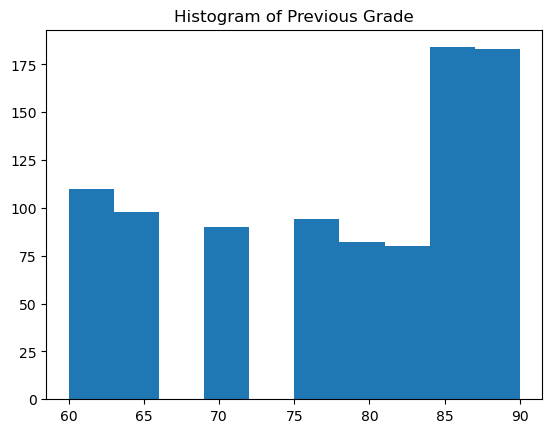

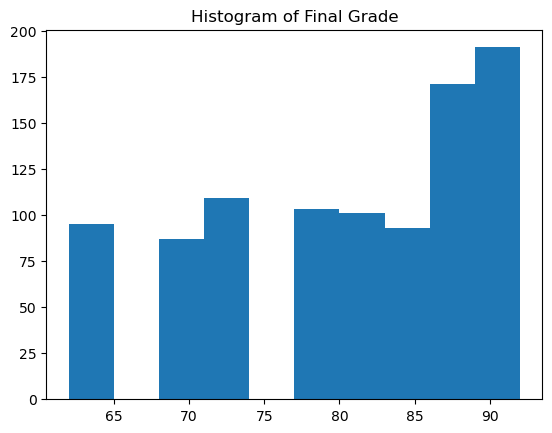

In [51]:
# Grades
plt.figure()
plt.hist(df["PreviousGrade"])
plt.title("Histogram of Previous Grade")
plt.show()

plt.figure()
plt.hist(df["FinalGrade"])
plt.title("Histogram of Final Grade")
plt.show()


This histograms above might imply a higher correlation between Previous Grade and Final Grade. But if you look at the sns pairplot between the two variables, you can see the students which had a higher Previous Grade could have low Final Grades and vice versa.


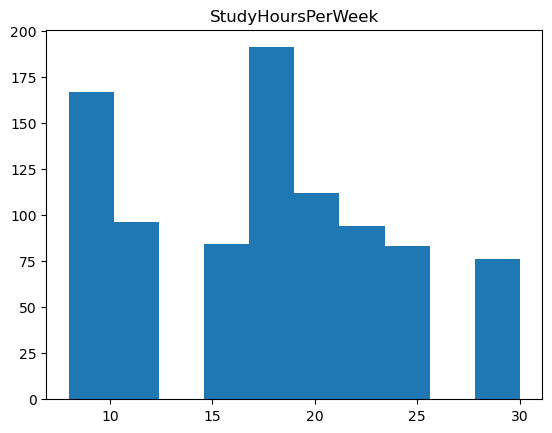

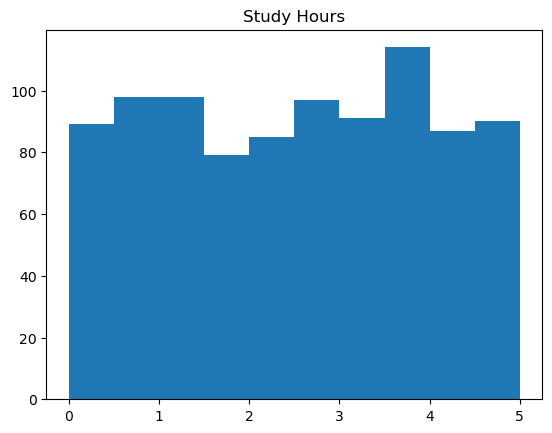

In [52]:
# Study hours
plt.figure()
plt.hist(df["StudyHoursPerWeek"])
plt.title("StudyHoursPerWeek")
plt.show()

plt.figure()
plt.hist(df["Study Hours"])
plt.title("Study Hours")
plt.show()


The scale of the two study hours columns a very different- because Study Hours scale isn't as clear compared to the scale of the StudyHoursperWeek we drop the Study Hours column for analysis.

In [54]:
df = df.drop(columns = ["Study Hours"])


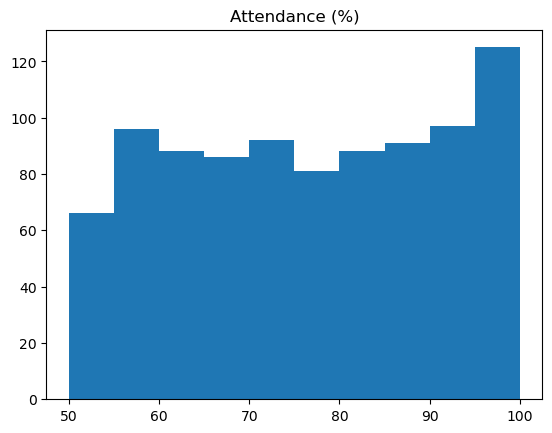

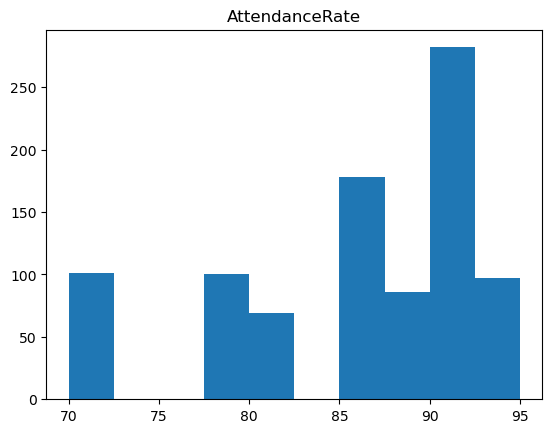

In [53]:
# Attendance
plt.figure()
plt.hist(df["Attendance (%)"])
plt.title("Attendance (%)")
plt.show()

plt.figure()
plt.hist(df["AttendanceRate"])
plt.title("AttendanceRate")
plt.show()


The histograms for the two attendance columns look very different. But given they both represent an attendance percentage, we choose to remove one of the two. This is because the feature importance for the two could be different for the model which would be confusing to interpret (for example, what if AttendanceRate has a high feature importance when predicting FinalGrade but Attendance (%) doesn't)? If the Kaggle dataset had more specific descriptors that distinguished between the two (for example maybe one is the attendance % for the year and one is overall attendance %) then both could have been included.


In [55]:
df = df.drop(columns = ["AttendanceRate"])


### Look at distribution of labels in object columns

In [57]:
for col in df.columns:
    if df[col].dtype == "object":
        print(col)
        print(df[col].value_counts())
        print()
        

Gender
Male      480
Female    423
Name: Gender, dtype: int64

ParentalSupport
High      327
Medium    312
Low       290
Name: ParentalSupport, dtype: int64

Online Classes Taken
True     470
False    457
Name: Online Classes Taken, dtype: int64



#### Gender and Online Classes Taken are boolean, so we replace they string values with 0 and 1

In [66]:
df[["Gender"]] = df[["Gender"]].replace({"Male": 0, "Female": 1})
df[["Online Classes Taken"]] = df[["Online Classes Taken"]].replace({True: 1, False: 0})


#### ParentalSupport has mutliple categories so apply dummy variables

We apply dummy variables for the parental support column which starts by making 3 boolean columns representing each category. For example, we create a High column with 1/0 representing 1 if the student has high parental support, 0 if the student doesn't, and then repeat for the other two categories. After we drop one of the 3 columns with drop_first=True, because the value for one column can be deduced by the other two- for example, if a student doesn't have high parental support or low parental support, the student has medium parental support.

In [61]:
column_dummy = pd.get_dummies(df["ParentalSupport"],drop_first=True)
df = pd.concat([df,column_dummy],axis=1)
df.drop(["ParentalSupport"], axis=1, inplace=True)


### Interpolation

In [68]:
df.isna().sum()


Gender                       47
StudyHoursPerWeek            47
PreviousGrade                29
ExtracurricularActivities    39
FinalGrade                    0
Attendance (%)               40
Online Classes Taken         23
Low                           0
Medium                        0
dtype: int64

Because there aren't a lot of missing values relative to the total number of students in the dataset, we interpolate based on the mean.

In [69]:
df = df.fillna(df.mean(numeric_only=True))
df[["Gender", "Online Classes Taken", "ExtracurricularActivities"]] = df[["Gender", "Online Classes Taken", "ExtracurricularActivities"]].astype("int")
df.head()


,Gender,StudyHoursPerWeek,PreviousGrade,ExtracurricularActivities,FinalGrade,Attendance (%),Online Classes Taken,Low,Medium
0,0,15.0,78.0,1,80.0,59.0,0,0,0
1,1,20.0,85.0,2,87.0,70.0,1,0,1
2,0,10.0,65.0,0,68.0,92.0,0,1,0
3,0,25.0,90.0,3,92.0,96.0,0,0,0
4,1,18.0,82.0,2,85.0,97.0,1,0,1


In [70]:
df.to_csv("processed_data.csv", index=False)

#### Plan of Analysis

##### Method 1
Use classification to predict the letter grade directly with RandomForestClassifier which is an ensemble method that will help prevent overfitting and is well suited for the categorical and integer input data.

##### Method 2
Use regression modeling with SVR to predict the FinalGrade value, assess a letter grade and comparing to the students actual final letter grade with accuracy score. 

#### General Notes
For each method:
* Hyperparameter tuning will be applied to optimize their accuracies.
* Accuracy scores of the two methods will be compared

For at least method 1, I'd also like to compare the feature importances of the classification model using only students with online class vs students without online classes to see if they're similar. If they aren't, I may consider splitting the input into two for modeling in the methods above.


# Supervised Modeling

## Base Model

### Method 1- Random Forest Classification

In [89]:
bins = [0, 60, 70, 80, 90, 101]  # Upper bound is exclusive for the bin
labels = [0, 1, 2, 3, 4]

tree_df = df.copy()
tree_df["FinalLetterGrade"] = pd.cut(df['FinalGrade'], bins=bins, labels=labels, right=False)
tree_df = tree_df.drop(columns=["FinalGrade"])
tree_df.head()


,Gender,StudyHoursPerWeek,PreviousGrade,ExtracurricularActivities,Attendance (%),Online Classes Taken,Low,Medium,FinalLetterGrade
0,0,15.0,78.0,1,59.0,0,0,0,3
1,1,20.0,85.0,2,70.0,1,0,1,3
2,0,10.0,65.0,0,92.0,0,1,0,1
3,0,25.0,90.0,3,96.0,0,0,0,4
4,1,18.0,82.0,2,97.0,1,0,1,3


In [107]:
# split into X_train, X_test, y_train, y_test
X, y = tree_df.drop(columns=["FinalLetterGrade"]), tree_df["FinalLetterGrade"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)


In [108]:
hyperparams = {'criterion': ['gini', 'entropy'],  
               'min_samples_split': [2,4,8,12], 
               'max_depth': [4,8,12],
               'min_samples_leaf': [2,4,8,12]}

rf_model = RandomForestClassifier()
gs = GridSearchCV(rf_model, hyperparams)
gs_fit = gs.fit(X, y)
gs_fit.best_params_


{'criterion': 'gini',
 'max_depth': 4,
 'min_samples_leaf': 2,
 'min_samples_split': 2}

In [109]:
optimal_rf_model = RandomForestClassifier(criterion='entropy', max_depth=4, min_samples_leaf=2, min_samples_split=2)
optimal_rf_model_fit = optimal_rf_model.fit(X_train, y_train)
y_pred = optimal_rf_model_fit.predict(X_test)
print(f"Accuracy Score of the Optimal Hyperparameter DT model: {accuracy_score(y_pred, y_test)}")
feature_importance_df = pd.DataFrame({"Feature": list(X_train.columns), "Importance": optimal_rf_model_fit.feature_importances_})
feature_importance_df = feature_importance_df.sort_values(by=["Importance"], ascending=False)
feature_importance_df


Accuracy Score of the Optimal Hyperparameter DT model: 0.3526315789473684


,Feature,Importance
4,Attendance (%),0.275959
1,StudyHoursPerWeek,0.209691
2,PreviousGrade,0.181580
3,ExtracurricularActivities,0.116768
0,Gender,0.076946
6,Low,0.051299
5,Online Classes Taken,0.047452
7,Medium,0.040304


The accuracy of this model is low, let's see if splitting the input data by the online class boolean and running each separately to see if that improves the accuracy.


In [115]:
# start with students not taking online classes
X, y = tree_df.loc[tree_df["Online Classes Taken"] == 0].drop(columns=["FinalLetterGrade", "Online Classes Taken"]), tree_df.loc[tree_df["Online Classes Taken"] == 0]["FinalLetterGrade"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

optimal_rf_model = RandomForestClassifier(criterion='entropy', max_depth=4, min_samples_leaf=2, min_samples_split=2)
optimal_rf_model_fit = optimal_rf_model.fit(X_train, y_train)
y_pred = optimal_rf_model_fit.predict(X_test)
print(f"Accuracy Score of the DT Model on Data without Online Classes: {accuracy_score(y_pred, y_test)}")
feature_importance_df = pd.DataFrame({"Feature": list(X_train.columns), "Importance": optimal_rf_model_fit.feature_importances_})
feature_importance_df = feature_importance_df.sort_values(by=["Importance"], ascending=False)
feature_importance_df

Accuracy Score of the DT Model on Data without Online Classes: 0.3645833333333333


,Feature,Importance
4,Attendance (%),0.305360
1,StudyHoursPerWeek,0.203715
2,PreviousGrade,0.192214
3,ExtracurricularActivities,0.110707
0,Gender,0.077331
5,Low,0.061368
6,Medium,0.049306


In [116]:
# start with students taking online classes
X, y = tree_df.loc[tree_df["Online Classes Taken"] == 1].drop(columns=["FinalLetterGrade", "Online Classes Taken"]), tree_df.loc[tree_df["Online Classes Taken"] == 1]["FinalLetterGrade"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

optimal_rf_model = RandomForestClassifier(criterion='entropy', max_depth=4, min_samples_leaf=2, min_samples_split=2)
optimal_rf_model_fit = optimal_rf_model.fit(X_train, y_train)
y_pred = optimal_rf_model_fit.predict(X_test)
print(f"Accuracy Score of the DT Model on Data without Online Classes: {accuracy_score(y_pred, y_test)}")
feature_importance_df = pd.DataFrame({"Feature": list(X_train.columns), "Importance": optimal_rf_model_fit.feature_importances_})
feature_importance_df = feature_importance_df.sort_values(by=["Importance"], ascending=False)
feature_importance_df


Accuracy Score of the DT Model on Data without Online Classes: 0.40425531914893614


,Feature,Importance
4,Attendance (%),0.267306
1,StudyHoursPerWeek,0.248330
2,PreviousGrade,0.190498
3,ExtracurricularActivities,0.145459
0,Gender,0.051208
6,Medium,0.051139
5,Low,0.046060


It appears the distinction between whether students are taking online classes is not significant in terms of how the response is predicted. The feature importances above are very similar for the two.

Let's see if we have better luck with the regression modeling method to extrapolate final letter grades.

### Method 2- Regression Modeling with SVR

#### Hyperparameter tuning for base input data

In [119]:
# split into X_train, X_test, y_train, y_test
X, y = df.drop(columns=["FinalGrade"]), df["FinalGrade"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)


In [120]:
hyperparams = {'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],  
               'degree': [2,3,4], 
               'epsilon': [0.01, 0.05, 0.1, 0.5]}

svr_model = SVR()
clf = GridSearchCV(svr_model, hyperparams)
clf_fit = clf.fit(X, y)
clf_fit.best_params_


{'degree': 2, 'epsilon': 0.01, 'kernel': 'sigmoid'}

In [121]:
optimal_svr_model = SVR(degree=2, epsilon=0.01, kernel="sigmoid")
optimal_svr_model_fit = optimal_svr_model.fit(X_train, y_train)
y_pred = optimal_svr_model_fit.predict(X_test)

mse = mean_squared_error(y_pred, y_test, squared=False)
print(mse)


10.306869172950337


Let's use the predictions for the regression model to derive an accuracy score from the letter grade

In [123]:
res_df = pd.DataFrame({"Prediction": y_pred, "Actuals": y_test})
res_df

,Prediction,Actuals
872,80.688614,72.0
568,80.377534,68.0
249,80.017714,78.0
331,80.278085,68.0
492,80.528998,72.0
...,...,...
379,80.240399,90.0
484,80.283016,87.0
679,80.416401,62.0
332,80.115241,80.0


In [124]:
bins = [0, 60, 70, 80, 90, 101]  # Upper bound is exclusive for the bin
labels = [0, 1, 2, 3, 4]

res_df["ActualLetterGrade"] = pd.cut(res_df['Actuals'], bins=bins, labels=labels, right=False)
res_df["PredictedLetterGrade"] = pd.cut(res_df['Prediction'], bins=bins, labels=labels, right=False)
res_df.head()

,Prediction,Actuals,ActualLetterGrade,PredictedLetterGrade
872,80.688614,72.0,2,3
568,80.377534,68.0,1,3
249,80.017714,78.0,2,3
331,80.278085,68.0,1,3
492,80.528998,72.0,2,3


In [125]:
print(f"Accuracy Score for Method 2 Using Regression: {accuracy_score(res_df['ActualLetterGrade'], res_df['PredictedLetterGrade'])}")


Accuracy Score for Method 2 Using Regression: 0.33157894736842103


# Result

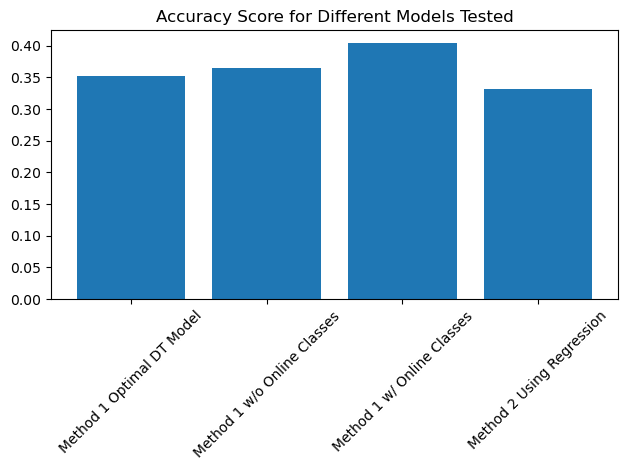

In [128]:
model_scores_df = pd.DataFrame({"method": ["Method 1 Optimal DT Model", "Method 1 w/o Online Classes", "Method 1 w/ Online Classes", "Method 2 Using Regression"],
                   "accuracy_score": [0.3526315789473684, 0.3645833333333333, 0.40425531914893614, 0.33157894736842103]})

plt.figure()
plt.bar(model_scores_df["method"], model_scores_df["accuracy_score"])
plt.xticks(rotation = 45)
plt.title("Accuracy Score for Different Models Tested")
plt.tight_layout()
plt.show()



The overall accuracy of the model from an accuracy_score standpoint was very poor, which means there's could be something that we may have missed in preparing the input data. Looking at the RMSE of the regression model, it performed slightly better, being about 10% within a student's final grade on average. From the feature selection of the random forest classifier, it appears that the predictors with the largest influence on a student's final grade are attendance, study hours per week, and their previous grade.


# Conclusions and Next Steps

It was very interesting to test using both classification and regression on a classification problem and comparing the performance of the two. The model performances didn't do as well as I expected- I suspect it had to do with the preparation of the input data because hyperparameter tuning was used on both the regression and classification models with GridSearchCV to optimize the hyperparameters used. It would have helpful to know the distinction between the two attendance and two hours studied columns to see if they could have both been used for modeling.

Next Steps:
* Play around with different combinations of columns- I dropped one of two attendance columns and hours studied columns, but would the models have performed better if none were removed? I'd suspect the random forest might have because it performs relatively well on a high feature set.
* Perform outlier detection on the input data- maybe more than the outlier with values 0 existed.
* If I were to continue refining one of the two methods I tried above, I'd continue looking into the regression modeling, testing different algorithms than the SVM to see if there was improvment. I'd focus on regression because two letter grades are not always  considered equal (e.g. 71% vs 79%) and with regression modeling you can model on the continuous scale


# References

https://scikit-learn.org/stable/modules/permutation_importance.html
